## ovr-svm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gc
import os
import re
import pickle
import sklearn
import sys
import string


from datetime import datetime
from sklearn.externals import joblib
from sklearn.metrics import f1_score, precision_score, recall_score,average_precision_score
from sklearn.model_selection import cross_val_score, GridSearchCV,ParameterGrid, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler,MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression,SGDClassifier

from tqdm import *

%matplotlib inline
%load_ext autoreload
%autoreload 1

In [2]:
src_dir = os.path.join(os.getcwd(), os.pardir, '../../')
sys.path.append(src_dir)

In [3]:
%aimport src.data.delicious_t140
%aimport src.helpers.labels
%aimport src.utils.dataframes, src.utils.clusters, src.utils.metrics,src.utils.plotting

In [28]:
from src.features.delicious_t140 import clean_text_delicious
from src.data.delicious_t140 import get_sample_from_cache
from src.helpers.labels import truncate_labels
from src.utils.metrics import ranking
from src.utils.dataframes import sample_rows
from src.utils.plotting import plot_micro_f1_at_k

In [39]:
MODELS_ROOT = os.path.abspath("../../../models/ranking/delicious-ovr-linear-svc-calibrated")
DATA_ROOT = "/media/felipe/SAMSUNG/delicious/delicioust140"
INTERIM_DATA_ROOT = os.path.abspath("../../../data/interim/delicious-t140/")
OUTPUT_FILE = 'output-linear-svc-'+ datetime.now().strftime('%Y-%m-%d-%H-%M-%S')+'.txt'

MAX_NB_WORDS = 500
SEED= 42
MIN_TAG_DF=10
SAMPLE_FRAC=20

In [18]:
np.random.seed(SEED)

In [19]:
docs_df = get_sample_from_cache(INTERIM_DATA_ROOT,SAMPLE_FRAC)

In [22]:
labels = docs_df["tags"].map(lambda tagstring: tagstring.split(","))
labels = truncate_labels(labels,MIN_TAG_DF)

In [23]:
mlb = MultiLabelBinarizer()

binary_labels = mlb.fit_transform(labels)

print("total number of unique tags: {} ".format(len(mlb.classes_)))

data = docs_df['contents'].values
indices = np.arange(len(data))
np.random.shuffle(indices)

data = [data[i] for i in indices]
targets = binary_labels[indices]
num_validation_samples = int(0.15 * len(data))

X_train = data[:-num_validation_samples]
Y_train = targets[:-num_validation_samples]
X_val = data[-num_validation_samples:]
Y_val = targets[-num_validation_samples:]

print('total number of train documents: {}'.format(len(X_train)))
print('total number of validation documents: {}'.format(len(X_val)))

total number of unique tags: 3305 
total number of train documents: 24432
total number of validation documents: 4311


In [24]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    # https://stackoverflow.com/a/39712590/436721
    ('clf', OneVsRestClassifier(CalibratedClassifierCV(LinearSVC(),cv=2),n_jobs=-1)),
])

parameters = [
    {
        "vect__max_features": [MAX_NB_WORDS]
    }
]

In [25]:
%%time

for g in ParameterGrid(parameters):
    print(g)
    pipeline.set_params(**g)
    
    pipeline.fit(X_train,Y_train)
    
    Y_pred_train = pipeline.predict_proba(X_train)    
    Y_pred_val = pipeline.predict_proba(X_val)
    
    ks = [1,2,3,4,5,6,7,8,9,10]
        
    # k is the number of neighbors so let's use at_k
    for k in ks:
        print("validation micro-F1 @{}: {}".format(k,ranking.micro_f1_at_k(Y_val,Y_pred_val,k=k,normalize=True))) 

{'vect__max_features': 500}
validation micro-F1 @1: 0.7574578469520103
validation micro-F1 @2: 0.7055025898956535
validation micro-F1 @3: 0.6647739004749122
validation micro-F1 @4: 0.6334350358600468
validation micro-F1 @5: 0.6067481093659104
validation micro-F1 @6: 0.5827237609928495
validation micro-F1 @7: 0.5605666722316297
validation micro-F1 @8: 0.5414560910109746
validation micro-F1 @9: 0.5231805724725944
validation micro-F1 @10: 0.506676827684154
CPU times: user 7min 55s, sys: 4.37 s, total: 7min 59s
Wall time: 8min 28s


In [37]:
pickle.dump(pipeline,open(MODELS_ROOT+'/model-sample-{}.p'.format(SAMPLE_FRAC),'wb'))

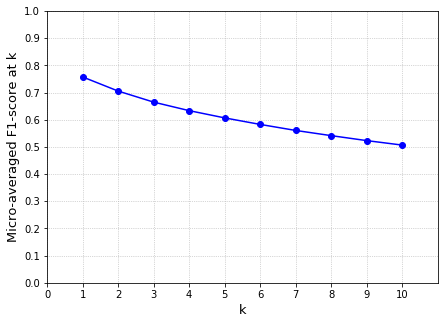

In [38]:
plt.clf()
img = plt.gcf()
ax = plt.gca()
validation_scores = [
    0.7574578469520103,0.7055025898956535,
    0.6647739004749122,0.6334350358600468,
    0.6067481093659104,0.5827237609928495,
    0.5605666722316297,0.5414560910109746,
    0.5231805724725944,0.506676827684154
]
plot_micro_f1_at_k(validation_scores,ax=ax)
plt.gcf().set_size_inches(7,5)
plt.gca().legend_.remove()
plt.show()